# BIDV (7:3)

16/16 [==============================] - 1s 13ms/step


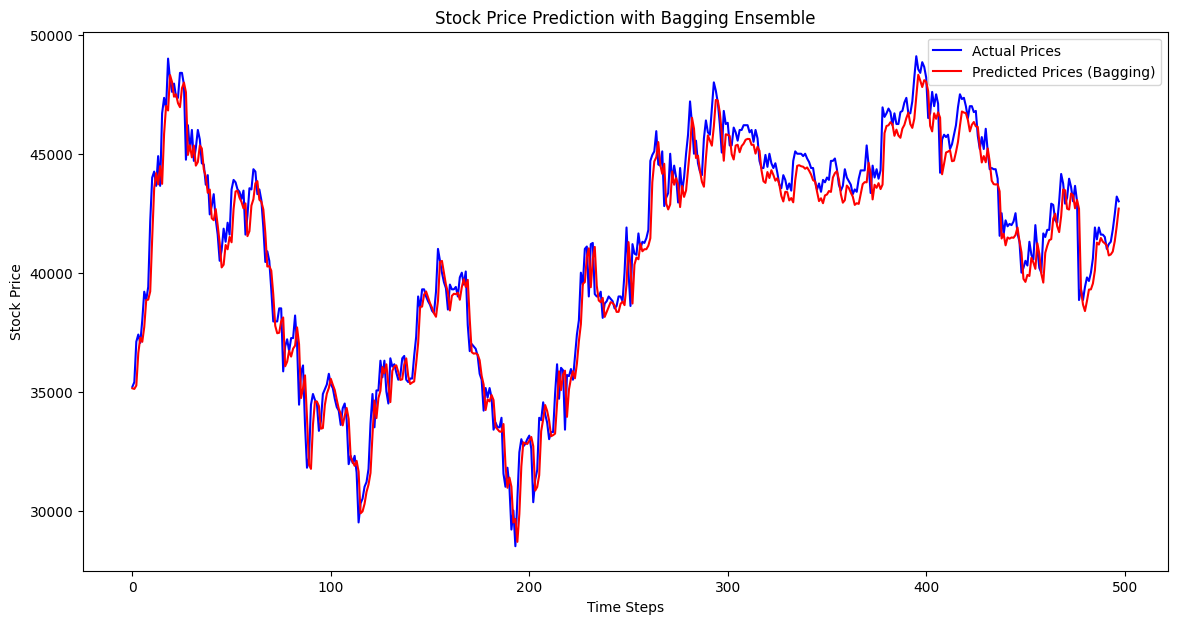

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load the dataset
df = pd.read_csv('/content/BIDV.csv',sep=",")
df1 = df.reset_index()['Price']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# Split the data into train and test sets
train_size = int(0.7 * len(df1))
test_size = len(df) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]

# Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t, t+1, t+2...t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the GRU model
def create_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_gru_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


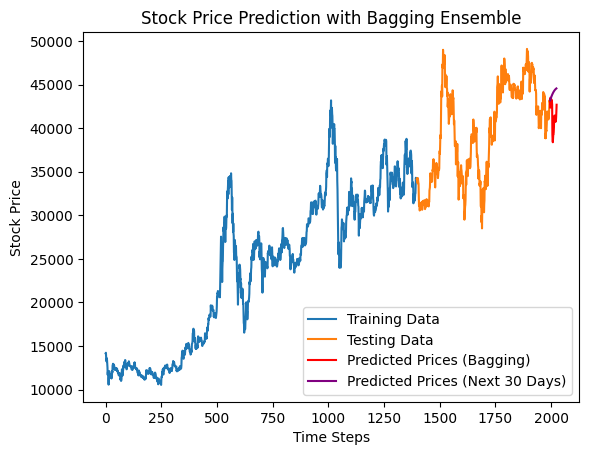

In [ ]:
# Predict for the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:

        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))

        yhat = base_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = base_model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

# Inverse transform the predictions for the next 30 days
final_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data),label='Training Data')

# Plot the testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data),label='Testing Data')

# Plot the predicted prices with bagging
plt.plot(np.arange(len(df1), len(df1) + 30), bagging_predictions_inv[-30:], label='Predicted Prices (Bagging)', color='red')

# Plot the predicted prices for the next 30 days
next_30_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 29, step=1)
plt.plot(next_30_days_index, final_predictions, label='Predicted Prices (Next 30 Days)', color='purple')

plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing}')

# Calculate MLSE for testing data
mlse_testing = np.mean(np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2
print(f'Testing MLSE: {mlse_testing}')


Testing RMSE: 995.6742210502357
Testing MAPE: 1.8772603788783944
Testing MLSE: 7.989366383931467e-05


# BIDV (8:2)

10/10 [==============================] - 1s 12ms/step


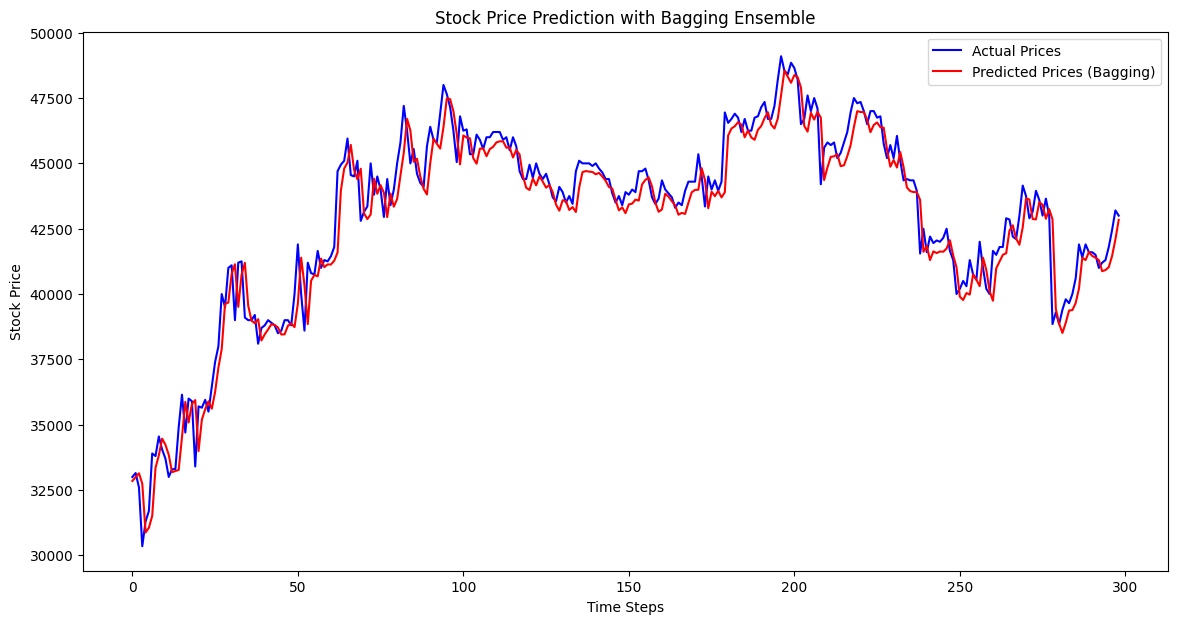

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load the dataset
df = pd.read_csv('/content/BIDV.csv')
df1 = df.reset_index()['Price']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# Split the data into train and test sets
train_size = int(0.8 * len(df1))
test_size = len(df) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]

# Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t, t+1, t+2...t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the GRU model
def create_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_gru_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


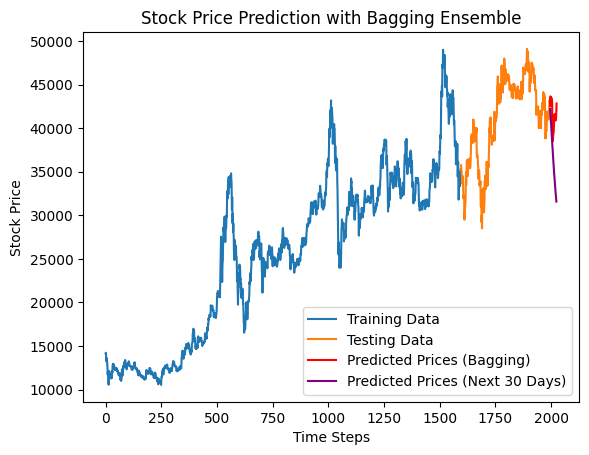

In [ ]:
# Predict for the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:

        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))

        yhat = base_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = base_model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

# Inverse transform the predictions for the next 30 days
final_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data),label='Training Data')

# Plot the testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data),label='Testing Data')

# Plot the predicted prices with bagging
plt.plot(np.arange(len(df1), len(df1) + 30), bagging_predictions_inv[-30:], label='Predicted Prices (Bagging)', color='red')

# Plot the predicted prices for the next 30 days
next_30_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 29, step=1)
plt.plot(next_30_days_index, final_predictions, label='Predicted Prices (Next 30 Days)', color='purple')

plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing:}')

# Calculate MLSE for testing data
mlse_testing = np.mean(np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2
print(f'Testing MLSE: {mlse_testing}')


Testing RMSE: 901.385682387134
Testing MAPE: 1.5453654548592397
Testing MLSE: 5.164952928208454e-05


# BIDV (9:1)

4/4 [==============================] - 0s 13ms/step


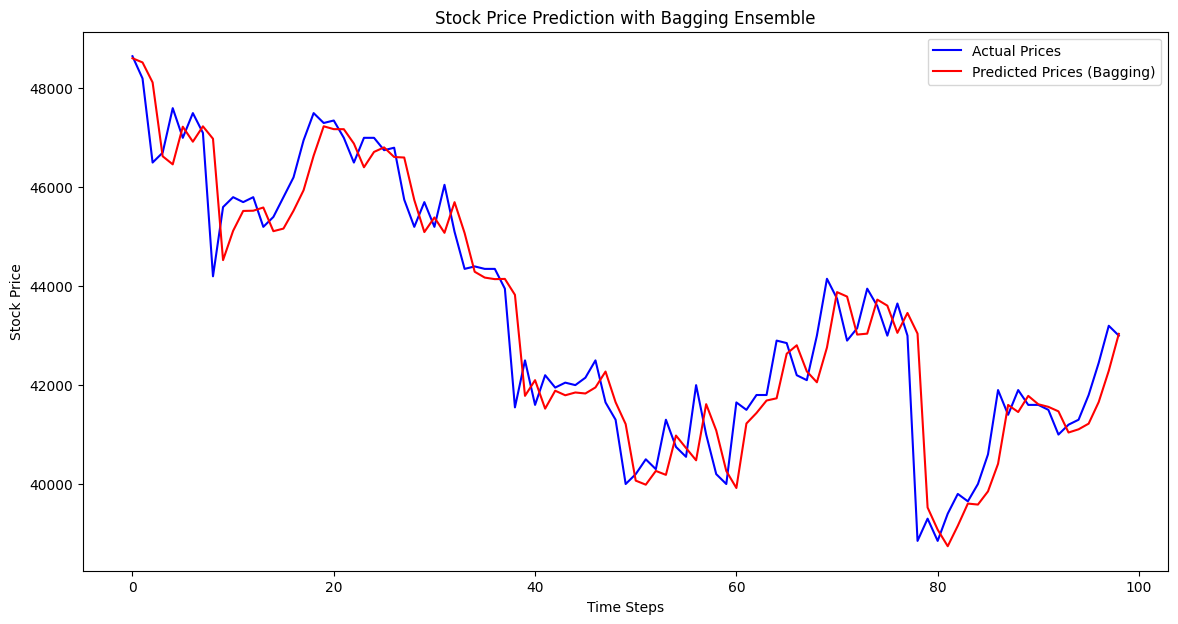

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load the dataset
df = pd.read_csv('/content/BIDV.csv')
df1 = df.reset_index()['Price']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# Split the data into train and test sets
train_size = int(0.9 * len(df1))
test_size = len(df) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]

# Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t, t+1, t+2...t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the GRU model
def create_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_gru_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


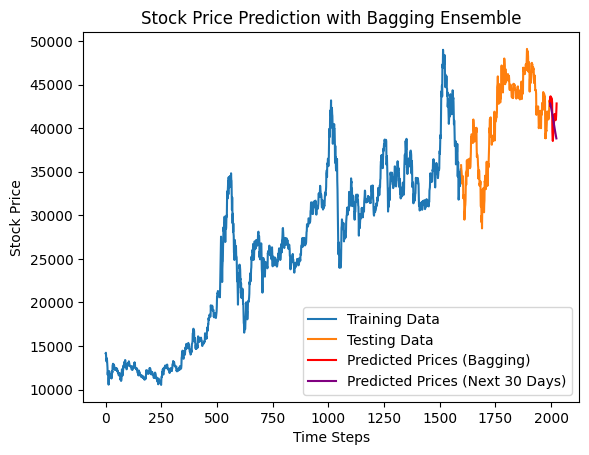

In [ ]:
# Predict for the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:

        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))

        yhat = base_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = base_model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

# Inverse transform the predictions for the next 30 days
final_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data),label='Training Data')

# Plot the testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data),label='Testing Data')

# Plot the predicted prices with bagging
plt.plot(np.arange(len(df1), len(df1) + 30), bagging_predictions_inv[-30:], label='Predicted Prices (Bagging)', color='red')

# Plot the predicted prices for the next 30 days
next_30_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 29, step=1)
plt.plot(next_30_days_index, final_predictions, label='Predicted Prices (Next 30 Days)', color='purple')

plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing:}')

# Calculate MLSE for testing data
mlse_testing = np.mean(np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2
print(f'Testing MLSE: {mlse_testing}')


Testing RMSE: 893.5866486678719
Testing MAPE: 1.5225095064346323
Testing MLSE: 4.284982367927156e-05
